<a href="https://colab.research.google.com/github/hauwaugidado/3mttproject/blob/main/3mtt_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# to load the data
data1 = pd.read_csv('/content/worldometer_data.csv')
data2 = pd.read_csv('/content/country_wise_latest.csv')

data = pd.merge(data1,data2)
data.to_csv('covid19.csv', index=False)

# inspecting the data
print (data.head())
print (data.info())
print (data.describe())


# Drop irrelevant columns
data = data.drop(['WHO Region','NewRecovered','NewDeaths','ActiveCases','TotalRecovered'],axis=1)

# Handling missing values - Improved handling
for col in ['TotalTests', 'Continent']:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].mean(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True) # Use mode for categorical
data.fillna(0, inplace=True) # Fill any remaining NaN with 0


# Convert data types
data['TotalCases'] = pd.to_numeric(data['TotalCases'], errors='coerce')
data['TotalDeaths'] = pd.to_numeric(data['TotalDeaths'], errors='coerce')
data['TotalTests'] = pd.to_numeric(data['TotalTests'], errors='coerce')
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')

# Removing rows with missing values after conversion
data.dropna(inplace=True)

# Feature engineering
data['Cases per million'] = data['TotalCases'] / (data['Population'] / 1000000)
data['Deaths per million'] = data['TotalDeaths'] / (data['Population'] / 1000000)
data['Tests per million'] = data['TotalTests'] / (data['Population'] / 1000000)
data['Death Rate'] = (data['TotalDeaths'] / data['TotalCases']) * 100
data['Positive Rate'] = (data['TotalCases'] / data['TotalTests']) * 100

# Removing outliers
data = data[data['Death Rate'] < 15]

# Displaying cleaned data
print(data.head())
print(data.info())
print(data.describe())

  Country/Region      Continent   Population  TotalCases  NewCases  \
0         Brazil  South America  212710692.0     2917562       NaN   
1         Russia         Europe  145940924.0      871894       NaN   
2   South Africa         Africa   59381566.0      538184       NaN   
3         Mexico  North America  129066160.0      462690    6590.0   
4           Peru  South America   33016319.0      455409       NaN   

   TotalDeaths  NewDeaths  TotalRecovered  NewRecovered  ActiveCases  ...  \
0      98644.0        NaN       2047660.0           NaN     771258.0  ...   
1      14606.0        NaN        676357.0           NaN     180931.0  ...   
2       9604.0        NaN        387316.0           NaN     141264.0  ...   
3      50517.0      819.0        308848.0        4140.0     103325.0  ...   
4      20424.0        NaN        310337.0           NaN     124648.0  ...   

   Active  New cases  New deaths  New recovered  Deaths / 100 Cases  \
0  508116      23284         614          337

<ipython-input-15-986ffb926b91>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


Data Shape: (130, 29)


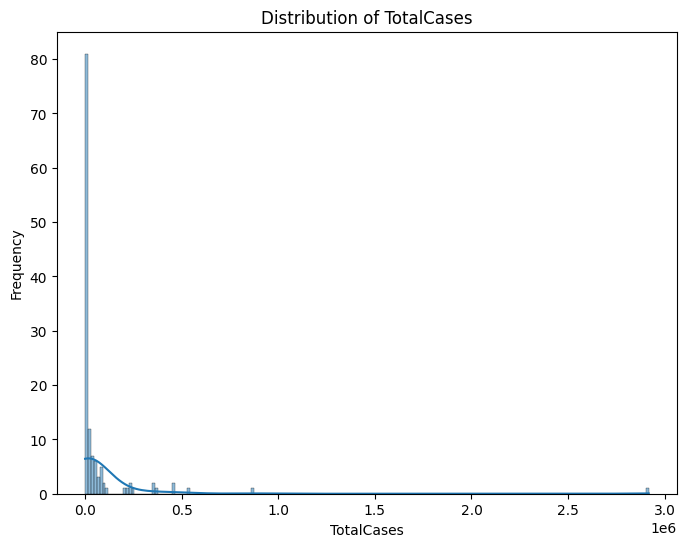

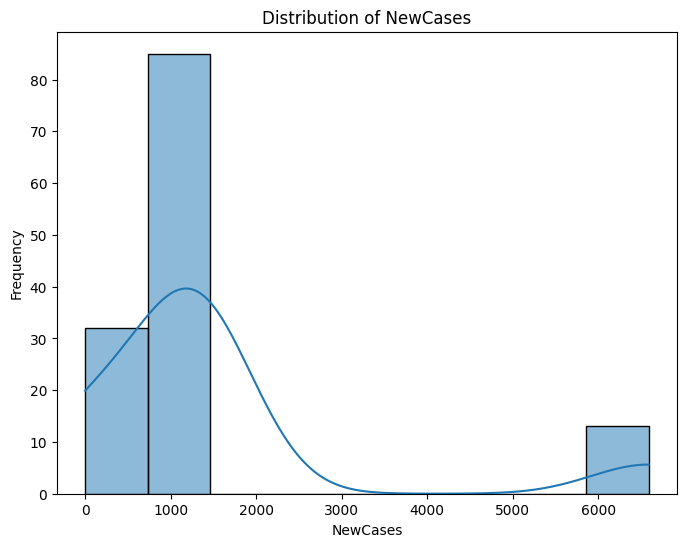

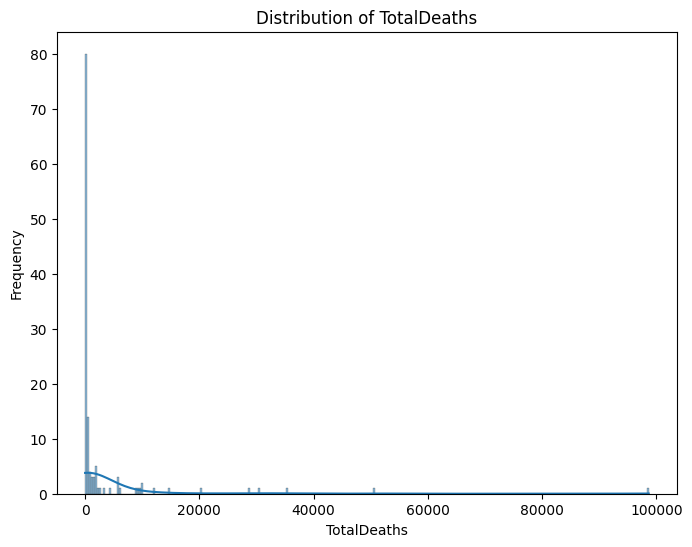

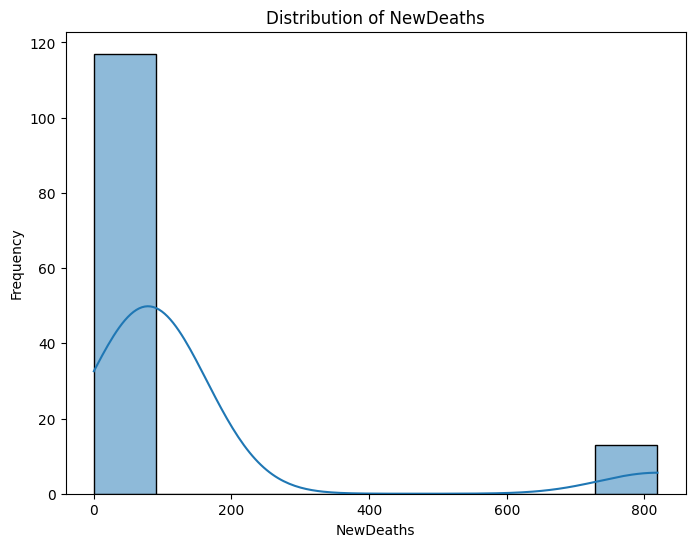

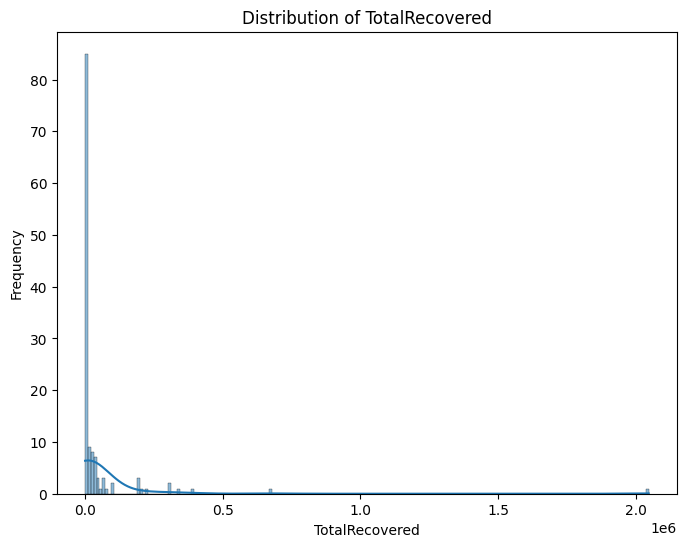

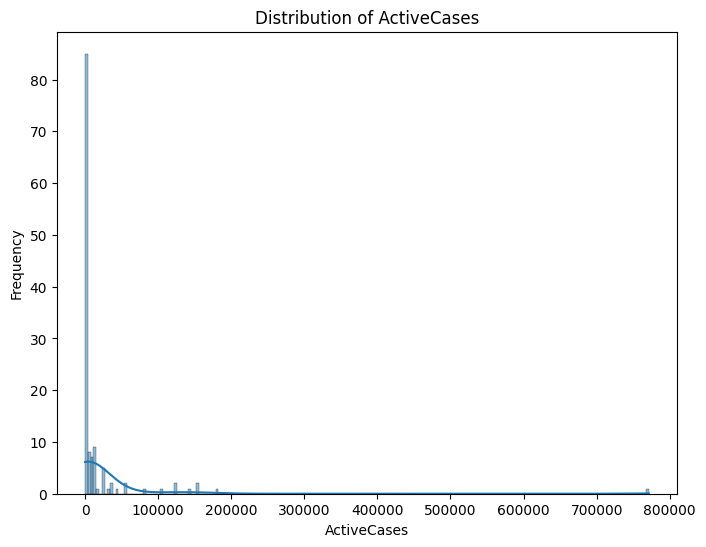

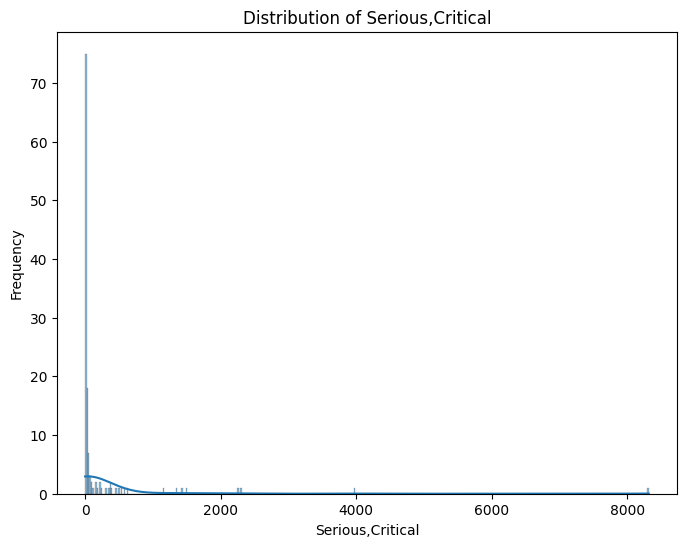

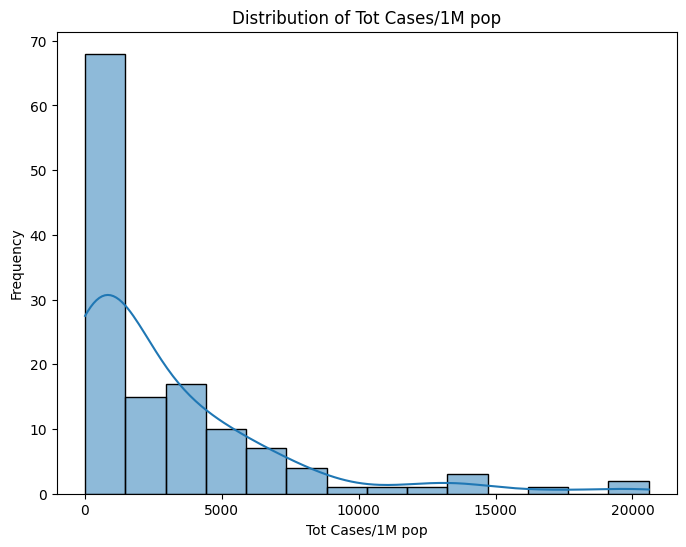

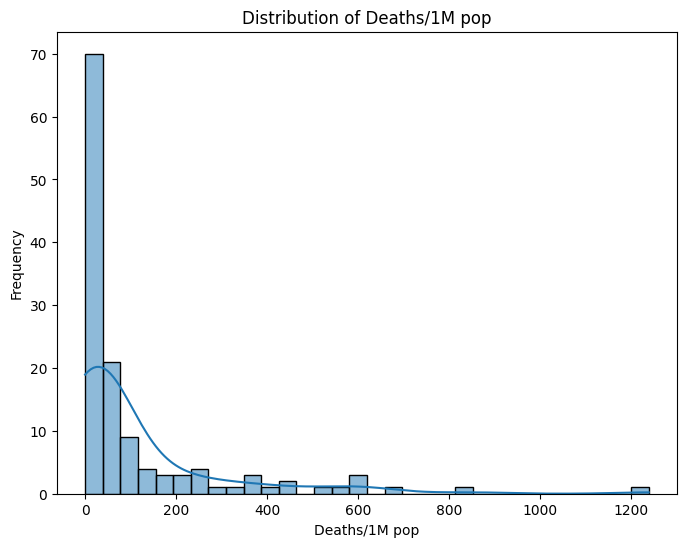

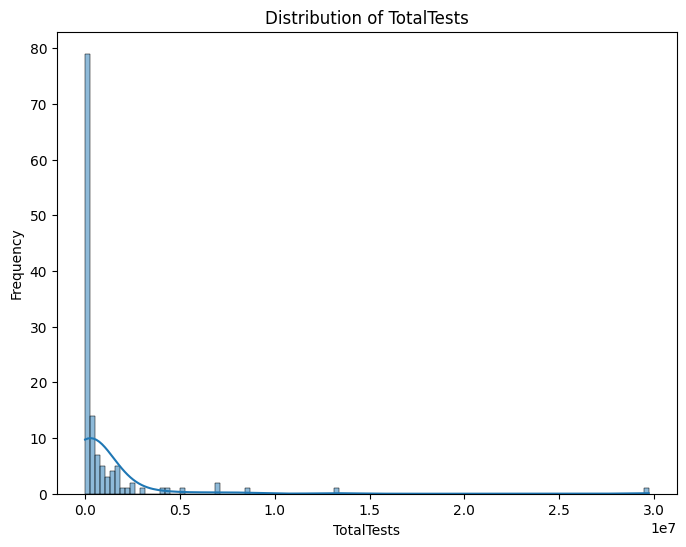

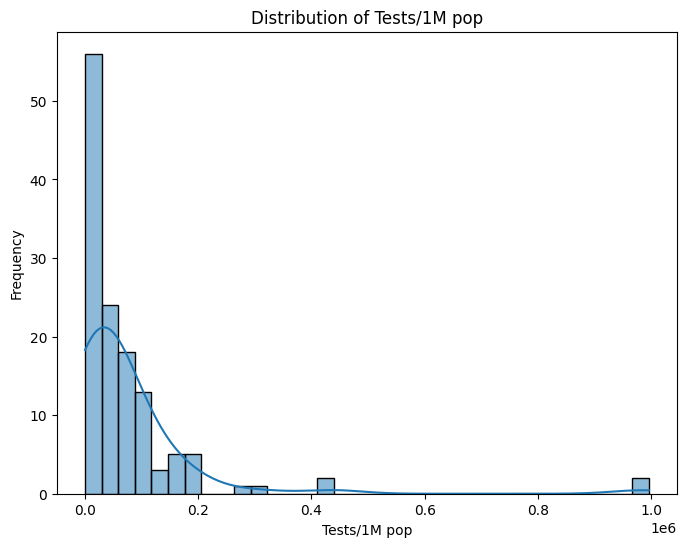

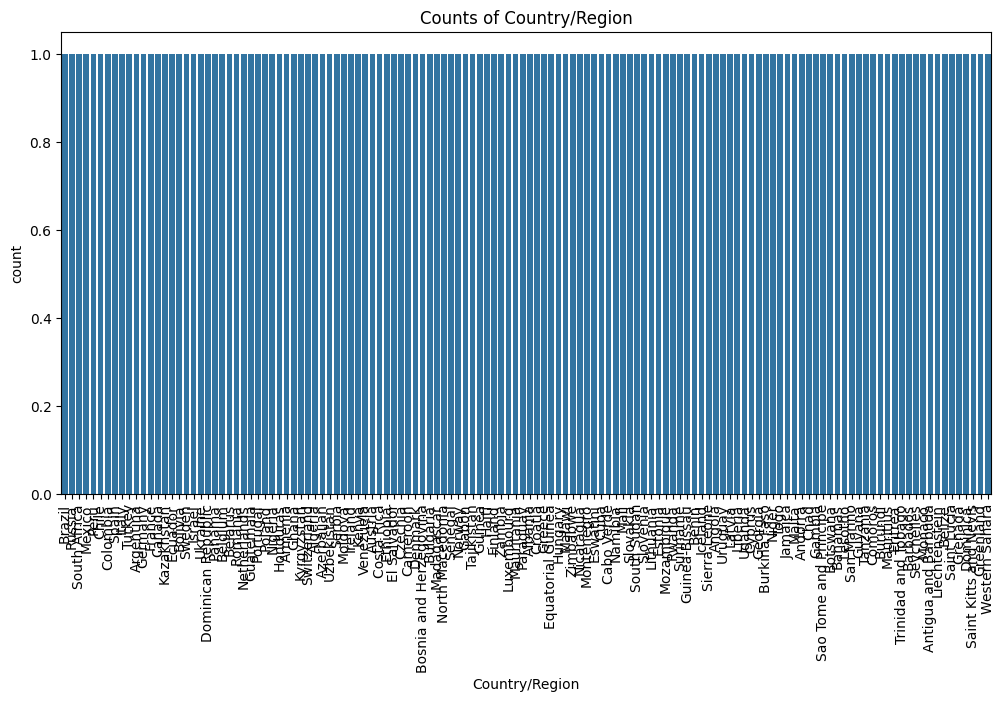

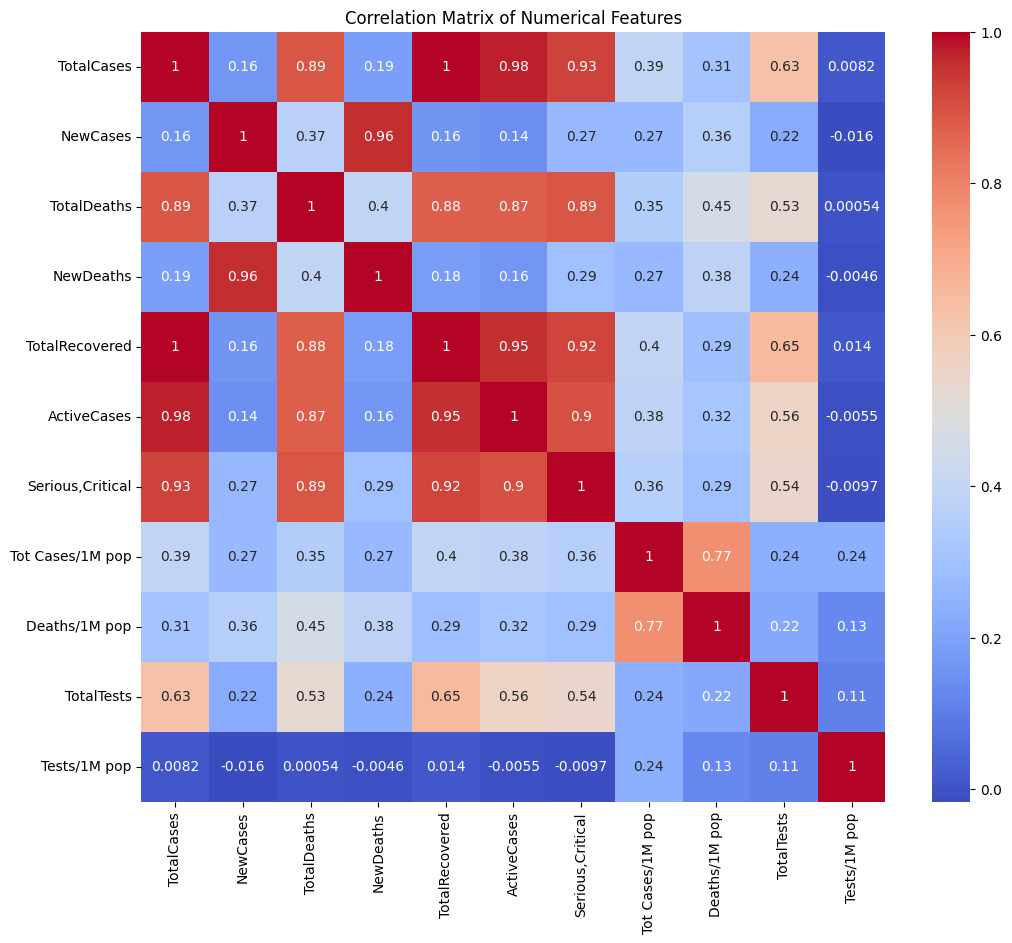

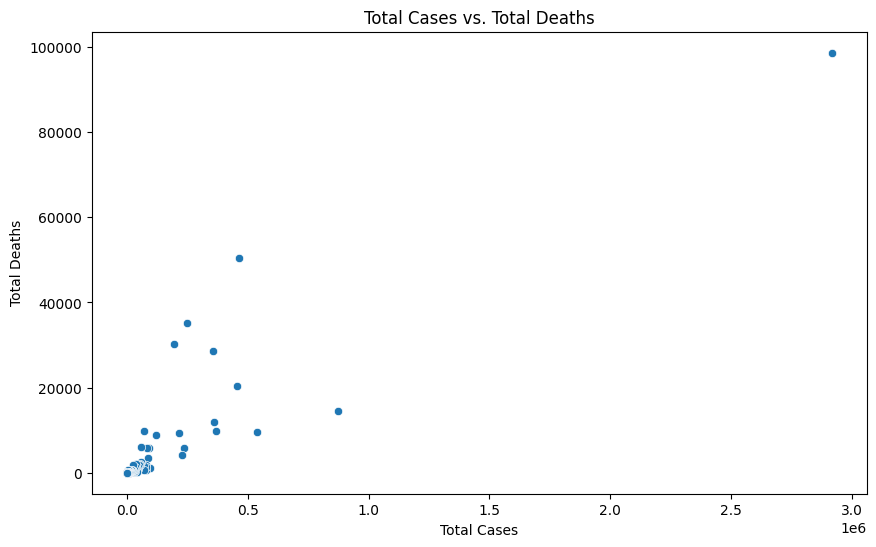

In [ ]:

# Exploratory Data Analysis
print("Data Shape:", data.shape)

# Numerical features distribution
numerical_features = ['TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop']
for col in numerical_features:
  plt.figure(figsize=(8, 6))
  sns.histplot(data[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

# Categorical features analysis
categorical_features = ['Country/Region'] # Add other categorical columns as needed

for col in categorical_features:
  plt.figure(figsize=(12, 6))
  sns.countplot(x=col, data=data)
  plt.xticks(rotation=90)
  plt.title(f'Counts of {col}')
  plt.show()

# Correlation matrix
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


# Example of bivariate analysis (replace with other relevant pairs)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalCases', y='TotalDeaths', data=data)
plt.title('Total Cases vs. Total Deaths')
plt.xlabel('Total Cases')
plt.ylabel('Total Deaths')
plt.show()

# Further analysis can be performed based on specific research questions.
# Add more plots and analysis based on your specific interests and the dataset.

In [20]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder


# Model Building and Evaluation (Improved with time-series considerations and multiple models)

# Encode the target variable for regression models
label_encoder = LabelEncoder()
data['Country_Encoded'] = label_encoder.fit_transform(data['Country/Region'])

# Define features and target variables for time-series/regression models
X = data[['TotalCases', 'TotalDeaths', 'TotalTests', 'Population', 'Cases per million', 'Deaths per million', 'Tests per million']]
y = data['Country_Encoded'] # Predict country using encoded labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
print("Linear Regression:")
print(f"Mean Squared Error: {lr_mse}")
print(f"R-squared: {lr_r2}")


# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # Example hyperparameters
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print("\nRandom Forest Regression:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R-squared: {rf_r2}")


# Feature Importance (for Random Forest)
feature_importances = rf_model.feature_importances_
feature_names = X.columns
for i, importance in enumerate(feature_importances):
    print(f"{feature_names[i]}: {importance}")

Linear Regression:
Mean Squared Error: 1204.2128476147877
R-squared: -0.027868088325287754

Random Forest Regression:
Mean Squared Error: 1438.9023730769234
R-squared: -0.2281897128325696
TotalCases: 0.09934903602693218
TotalDeaths: 0.09895136474788295
TotalTests: 0.1116967599513754
Population: 0.12117609124945389
Cases per million: 0.17800632158259094
Deaths per million: 0.21100045140351714
Tests per million: 0.1798199750382476
